# Testing the correlation of Neanderthal admixture with time

In [1]:
suppressPackageStartupMessages(library(GenomicRanges))
library(rtracklayer)
library(ggplot2)
library(magrittr)
library(stringr)
suppressPackageStartupMessages(library(dplyr))
library(binom)
library(plotrix)
library(RColorBrewer)

Creating a generic function for ‘nchar’ from package ‘base’ in package ‘S4Vectors’


In [2]:
setwd("/mnt/scratch/mateja/Early_modern_humans/nuclear_captures/Archaic_admixture_final/Test_high_cov_with_Altai_only_positions")

In [3]:
options(repr.plot.width=5, repr.plot.height=4)
options(jupyter.plot_mimetypes = setdiff(getOption('jupyter.plot_mimetypes'), 'image/svg+xml'))

In [4]:
# Load a BED file with allele states in an individual. Annotate each
# such site with B statistic value and a binary value describing if
# this individual carries an archaic-like SNP.
load_snps <- function(bed_filename) {
    # first load the informative states in a given individual
    test_bed <- import.bed(bed_filename, extraCols=c(afr="character", arch="character", test="character"))
    
    # which sites carry an archaic-like snp?
    test_bed$archaic <- as.integer(test_bed$arch == test_bed$test)
    
    test_bed[, "archaic"]
}


# Calculate the proportion of sharing of derived allele in a given bin.
admixture_prop <- function(info_sites) {    
    mean(info_sites$archaic) * 100
}


# Calculate the proportion of sharing of derived allele in a given bin
# and corresponding confidence intervals.
admixture_prop_ci <- function(info_sites) {    
    ci <- binom.confint(sum(info_sites$archaic), length(info_sites), method="wilson")
    
    return(c(mean=ci$mean, lower=ci$lower, upper=ci$upper) * 100)
}


# Extract the sample name from the given path to the BED file.
get_sample_name <- function(bed_file_path) {
    basename(bed_file_path) %>%
        str_replace("\\.bed", "") %>%
        str_replace("_deam_L35MQ37_majority_call", "") %>%
        str_replace("_L35MQ37_majority_call", "") %>%
        str_replace_all("_", " ")
}


# Calculate the jackknife estimate of admixture proportions on a given
# list of GRanges objects (corresponding to blocks of SNPs).
#
# This function is based on the jackknife method described in "Randomization,
# Bootstrap and Monte Carlo Methods in Biology (Third Edition)", 2007, page 29,
# written by Bryan. F. J. Manly.
block_jackknife <- function(blocks, theta) {
    n <- length(blocks)

    # iterate through blocks, leaving one at each time and calculate
    # the result of theta on remaining concatenated blocks
    jack_values <- rep(0, length(blocks))
    for (i in 1 : n) {
        jack_values[i] <- blocks[-i] %>% unlist %>% theta
    }

    # calculate the overall statistic for all data points (without blocks)
    theta_hat <- unlist(blocks) %>% theta

    # calculate the pseudovalues, jackknife estimate and confidence intervals
    pseudo_values <- n * theta_hat - (n - 1) * jack_values
    jack_estimate <- mean(pseudo_values)
    jack_ci <- jack_estimate + c(-qt(0.975, n - 1) * sqrt(var(pseudo_values)/n),
                                  qt(0.975, n - 1) * sqrt(var(pseudo_values)/n))
    
    return(list(jack_estimate=jack_estimate,
                jack_ci=jack_ci,
                jack_values=jack_values))
}


# Split the given list of SNPs into a defined number of blocks.
split_into_blocks <- function(info_sites, n_blocks) {
    block_size <- length(info_sites) %/% n_blocks
    block_breaks <- seq(1, length(info_sites), block_size)

    # split the list of SNPs into blocks
    snps_blocks <- split(info_sites, findInterval(seq_along(info_sites), block_breaks))
    
    # trim the list so that each block contains an equal number of SNPs
    snps_blocks <- snps_blocks[-length(snps_blocks)]
       
    return(snps_blocks)
}


# Get a p-value from the lm model object.
get_lm_pvalue <- function(lm_result) {
    fs <- summary(reg)$fstatistic
    as.numeric(pf(fs[1], fs[2], fs[3], lower.tail=FALSE))
}


# Read in the table of sample ages.
read_sample_ages <- function() {
    sample_ages <-
        pipe("cut -f1,3 /r1/people/alexander_huebner/Documents/StonekingLab/EarlyModernHumans_neaAncestry/archaicancestry.csv") %>%
        read.table(sep="\t", header=TRUE) %>%
        rename(name=ID) %>%
        filter(name != "Oase1") %>%
        unique %>%
        mutate(name=str_replace_all(name, " ", "")) %>%
        mutate(name=str_replace_all(name, "Dolni", "DolniVestonice"))
    
    sample_ages
}


# Plot the results of correlation and linear regression fit.
time_correlation_test <- function(df) {  
    filtered_df <- df[! df$name %in% c("Kostenki12", "DolniVestonice15", "Pavlov1", "Ostuni2", "Continenza"), ]
    reg <- lm(filtered_df$prop ~ filtered_df$age)
    cor_test <- cor.test(filtered_df$prop, filtered_df$age)
    
    p <- ggplot(df, aes(x=age, y=prop)) +
         geom_point(aes(shape=name, color=name), size=3) +
         geom_errorbar(aes(ymin=lower, ymax=upper, color=name)) +
         scale_shape_manual(values=1:nrow(df)) 
    
    p <- p + geom_abline(intercept=coef(reg)[1], slope=coef(reg)[2])
    # p <- p + stat_smooth(method="lm", color="black")
    
    p <- p + annotate("text", label = paste("r =", round(cor_test$estimate, digits=3)), x = 20000, y = 4, size=3.5) +
             annotate("text", label = paste("F-ratio =", round(summary(reg)$fstatistic["value"], digits=3)), x = 20000, y = 3.75, size=3.5) +
             annotate("text", label = paste("p-value =", round(cor_test$p.value, digits=3)), x = 20000, y = 3.5, size=3.5)
    
    p <- p + scale_y_continuous(limits=c(0, 4)) +
             ylab("alleles matching Neanderthal [%]") +
             xlab("years before present") + guides(shape = guide_legend(ncol = 2, byrow = TRUE)) +
             theme(legend.title=element_blank())
    
    p <- p + theme(legend.position="none")

#    print(summary(reg))
#    print(cor_test)
    
    plot(p)
}

## Load ages of all samples

In [5]:
sample_ages <- read_sample_ages()

<br><br><br><br><br><br><br><br><br><br>
# Correlation tests based on capture EMH and high-coverage data

## Load SNP data for each EMH individual

In [6]:
# take names of all BED files except Oase1 and Oase1 nonUSER
#bed_files <- list.files("Majority_call_low_coverage_deam_only/", pattern="bed$", full.names=TRUE) %>% .[!grepl("Oase1", .)]
bed_files <- list.files("Majority_call_low_coverage/", pattern="bed$", full.names=TRUE) %>% .[!grepl("Oase1", .)]

# extract sample names from filenames and modify them so
# that they correspond to the names in the ages data frame
sample_names <- sapply(bed_files, get_sample_name) %>%
    str_replace_all(" ", "") %>%
    str_replace_all("all", "") %>%    # filename for AfontovaGora for all sequences inconsistently named
    str_replace("Grotta", "Continenza") %>%
    str_replace("AfontovaGora", "AfontovaGora3")

# load archaic informative positions from all BED files into a list
snps_per_sample <- sapply(bed_files, load_snps)
names(snps_per_sample) <- sample_names

In [7]:
# sort the list of sample data based on age estimates
snps_per_sample <- snps_per_sample[sample_ages$name]

## Load the high-coverage individuals

In [8]:
sample_ages <- rbind(data.frame(name="Ust-Ishim", age=45000), sample_ages, data.frame(name=c("French", "Han", "Sardinian"), age=c(0, 0, 0)))

In [9]:
bed_files <- list.files("/mnt/scratch/mateja/Early_modern_humans/nuclear_captures/Archaic_admixture_final/Altai_homozygous_and_YRI_at_high_frequency/highcov",
                        pattern="bed$", full.names=TRUE) %>%
                 .[grepl("Ust-Ishim|French|Han|Sardinian", .)]

highcov_names <- sapply(bed_files, get_sample_name)

# load archaic informative positions from all BED files into a list
snps_for_highcov <- sapply(bed_files, load_snps)
names(snps_for_highcov) <- highcov_names

## Join the high-coverage and EMH SNP lists

In [10]:
snps_per_sample <- c(snps_per_sample, snps_for_highcov)

<br><br><br><br><br>
# Correlation based on jackknife estimates of Neanderthal admixture

In [11]:
n <- length(snps_per_sample)
jk_admix_df <- data.frame(name=character(n), n_sites=integer(n), age=integer(n), prop=numeric(n), lower=numeric(n), upper=numeric(n), stringsAsFactors=FALSE)

In [12]:
n_blocks <- 1000

for (i in seq_along(snps_per_sample)) {
    sample_name <- names(snps_per_sample)[i]
    sample_snps <- snps_per_sample[[i]]
    
    snp_blocks <- split_into_blocks(sample_snps, n_blocks)
    
    jk_result <- block_jackknife(snp_blocks, admixture_prop)
    
    jk_admix_df[i, ] <- list(sample_name,
                             length(sample_snps),
                             sample_ages[which(sample_ages$name == sample_name), "age"],
                             jk_result$jack_estimate,
                             jk_result$jack_ci[1],
                             jk_result$jack_ci[2])
}

## Jackknifing &mdash; Including Ust-Ishim and B-team

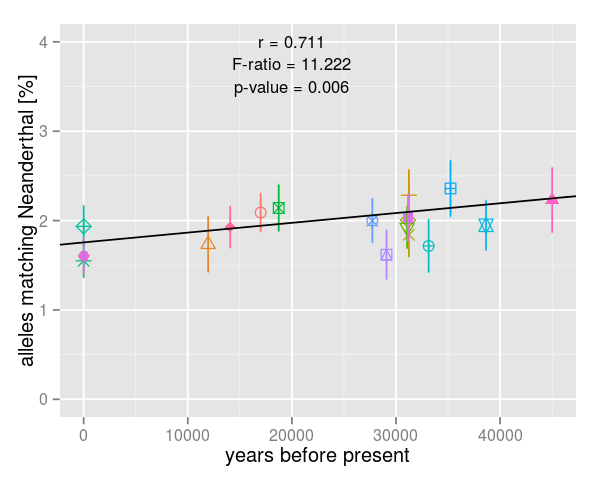

In [13]:
time_correlation_test(jk_admix_df)

## Jackknifing &mdash; Excluding Ust-Ishim and including B-team

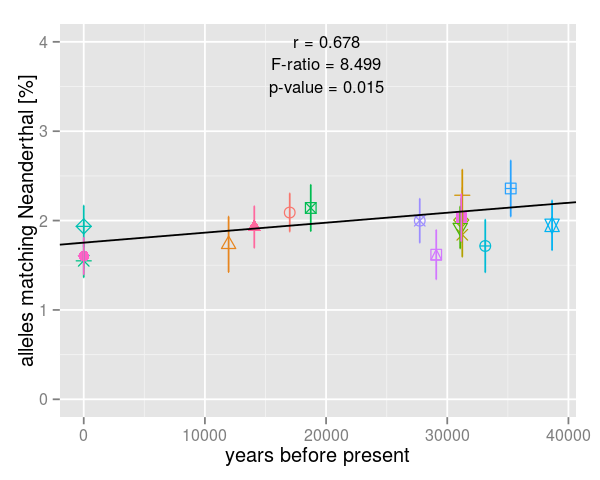

In [14]:
time_correlation_test(filter(jk_admix_df, (! name %in% c("Ust-Ishim"))))

## Jackknifing &mdash; Including Ust-Ishim and excluding B-team

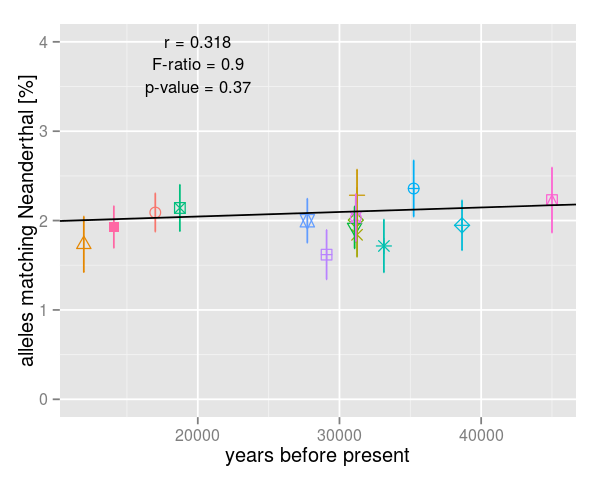

In [15]:
time_correlation_test(filter(jk_admix_df, (! name %in% c("French", "Han", "Sardinian"))))

## Jackknifing &mdash; Only our capture EMH samples

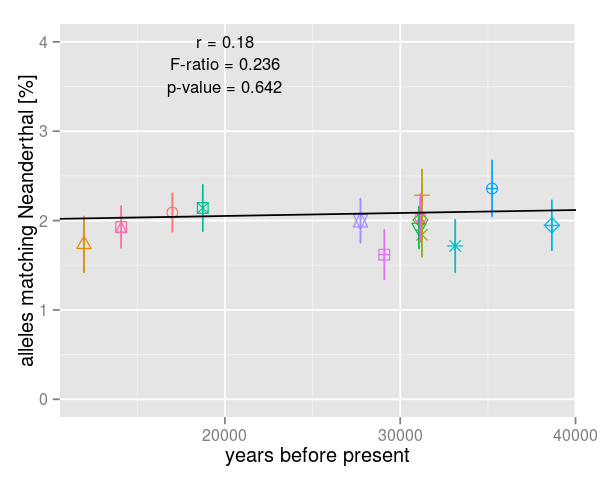

In [16]:
time_correlation_test(filter(jk_admix_df, (! name %in% c("Ust-Ishim", "French", "Han", "Sardinian"))))

<br><br><br><br><br>
# Correlation based on binomial estimates of Neanderthal admixture

In [17]:
n <- length(snps_per_sample)
binom_admix_df <- data.frame(name=character(n), n_sites=integer(n), age=integer(n), prop=numeric(n), lower=numeric(n), upper=numeric(n), stringsAsFactors=FALSE)

In [18]:
for (i in seq_along(snps_per_sample)) {
    sample_name <- names(snps_per_sample)[i]
    sample_snps <- snps_per_sample[[i]]
    
    prop_ci <- admixture_prop_ci(sample_snps)
    
    binom_admix_df[i, ] <- list(sample_name,
                                length(sample_snps),
                                sample_ages[which(sample_ages$name == sample_name), "age"],
                                prop_ci["mean"],
                                prop_ci["lower"],
                                prop_ci["upper"])
}

## Binomial estimates &mdash; Including Ust-Ishim and B-team

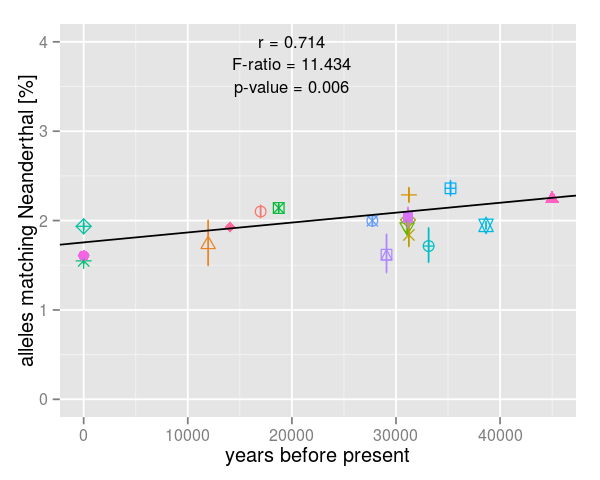

In [19]:
time_correlation_test(binom_admix_df)

## Binomial estimates &mdash; Excluding Ust-Ishim and including B-team

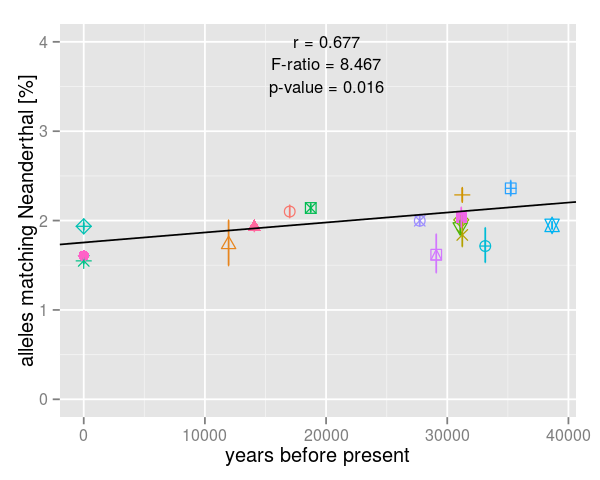

In [20]:
time_correlation_test(filter(binom_admix_df, (! name %in% c("Ust-Ishim"))))

## Binomial estimates &mdash; Including Ust-Ishim and excluding B-team

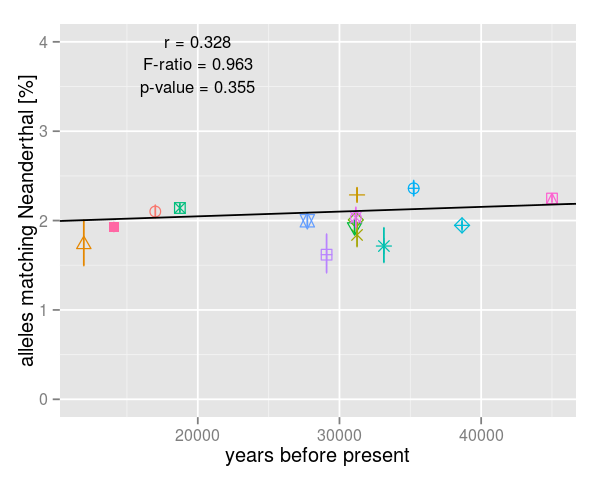

In [21]:
time_correlation_test(filter(binom_admix_df, (! name %in% c("French", "Han", "Sardinian"))))

## Binomial estimates &mdash; Only our capture EMH samples

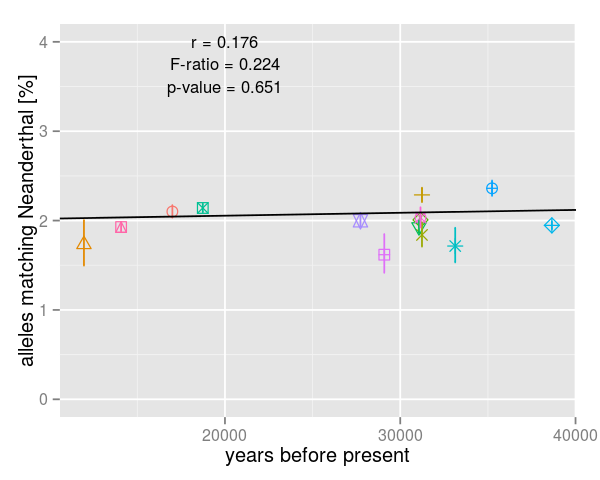

In [22]:
time_correlation_test(filter(binom_admix_df, (! name %in% c("Ust-Ishim", "French", "Han", "Sardinian"))))

<br><br><br><br><br><br><br><br><br><br>
# Correlation tests using French control of EMH and high-coverage samples

All analyses bellow are performed for all individuals on positions which are overlapping sites in French using alleles in the French individual. Therefore, we should not see any kind of correlation with time.

In [23]:
sample_ages <- read_sample_ages()

In [24]:
# take names of all BED files except Oase1 and Oase1 nonUSER
#bed_files <- list.files("Final_individuals_deam_L35MQ37/", pattern="^French_.*bed$", recursive=TRUE, full.names=TRUE) %>%
#    .[!grepl("Oase1", .)]
bed_files <- list.files("Final_individuals_all_L35MQ37/", pattern="^French_.*bed$", recursive=TRUE, full.names=TRUE) %>%
    .[!grepl("Oase1", .)]

# extract sample names from filenames and modify them so
# that they correspond to the names in the ages data frame
sample_names <- sapply(bed_files, get_sample_name) %>%
    str_replace_all(" ", "") %>%
    str_replace_all("French", "") %>%
    str_replace_all("deam", "") %>%
    str_replace("Grotta", "Continenza") %>%
    str_replace("Afontovagora", "AfontovaGora3")

# load archaic informative positions from all BED files into a list
snps_per_sample <- sapply(bed_files, load_snps)
names(snps_per_sample) <- sample_names

In [25]:
# sort the list of sample data based on age estimates
snps_per_sample <- snps_per_sample[sample_ages$name]

## Load the high-coverage individuals

In [26]:
sample_ages <- rbind(data.frame(name="Ust-Ishim", age=45000), sample_ages, data.frame(name=c("French", "Han", "Sardinian"), age=c(0, 0, 0)))

In [27]:
# take names of BED files from high-coverage individuals
bed_files <- list.files("High_cov_individuals_intersect_with_French/", pattern="^French.*bed$", recursive=TRUE, full.names=TRUE) %>%
                 .[grepl("Ust_Ishim|Han|Sardinian", .)]
bed_files <- c(bed_files, "/mnt/scratch/mateja/Early_modern_humans/nuclear_captures/Archaic_admixture_final/Test_high_cov_with_Altai_only_positions/High_coverage_individuals/French.bed")

# extract sample names from filenames and modify them so
# that they correspond to the names in the ages data frame
highcov_names <- sapply(bed_files, get_sample_name) %>%
    str_replace_all("French ", "") %>%
    str_replace_all("Ust Ishim", "Ust-Ishim") %>%
    str_replace_all("final positions", "") %>%
    str_replace_all(" ", "")

# load archaic informative positions from all BED files into a list
snps_for_highcov <- sapply(bed_files, load_snps)
names(snps_for_highcov) <- highcov_names

## Join the high-coverage and EMH lists

In [28]:
snps_per_sample <- c(snps_per_sample, snps_for_highcov)

<br><br><br><br><br>
# Correlation test based on jackknife estimates of Neanderthal admixture

In [29]:
n <- length(snps_per_sample)
jk_admix_df <- data.frame(name=character(n), n_sites=integer(n), age=integer(n), prop=numeric(n), lower=numeric(n), upper=numeric(n), stringsAsFactors=FALSE)

In [30]:
n_blocks <- 1000

for (i in seq_along(snps_per_sample)) {
    sample_name <- names(snps_per_sample)[i]
    sample_snps <- snps_per_sample[[i]]
    
    snp_blocks <- split_into_blocks(sample_snps, n_blocks)
    
    jk_result <- block_jackknife(snp_blocks, admixture_prop)
    
    jk_admix_df[i, ] <- list(sample_name,
                             length(sample_snps),
                             sample_ages[which(sample_ages$name == sample_name), "age"],
                             jk_result$jack_estimate,
                             jk_result$jack_ci[1],
                             jk_result$jack_ci[2])
}

## Jackknifing &mdash; Including Ust-Ishim and B-team (French control)

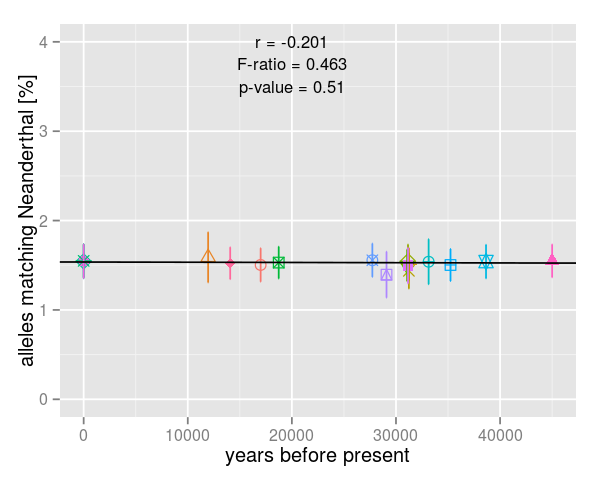

In [31]:
time_correlation_test(jk_admix_df)

## Jackknifing &mdash; Excluding Ust-Ishim and including B-team (French control)

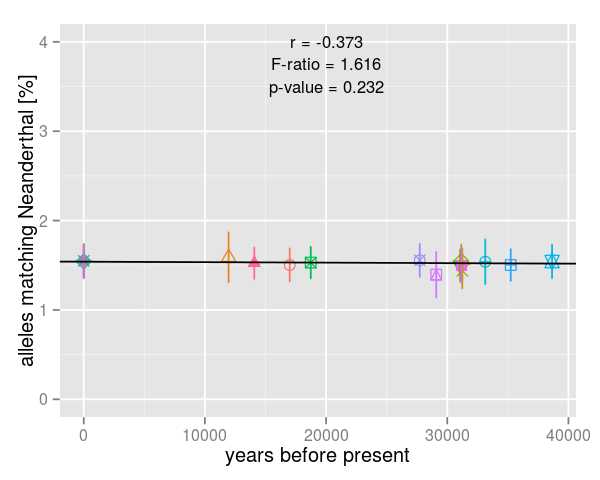

In [32]:
time_correlation_test(filter(jk_admix_df, (! name %in% c("Ust-Ishim"))))

## Jackknifing &mdash; Including Ust-Ishim and excluding B-team (French control)

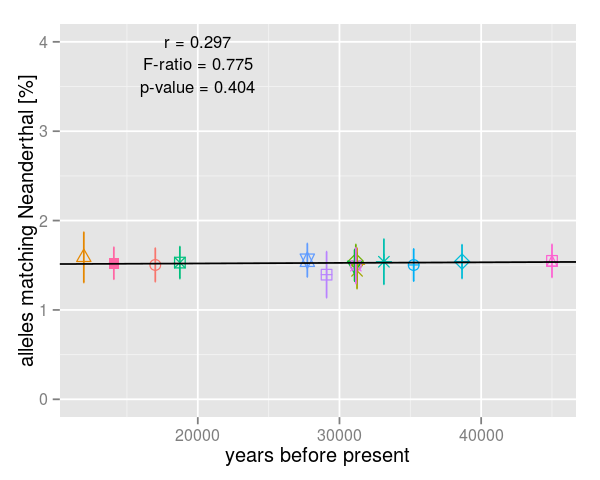

In [33]:
time_correlation_test(filter(jk_admix_df, (! name %in% c("French", "Han", "Sardinian"))))

## Jackknifing &mdash; Only our capture EMH samples (French control)

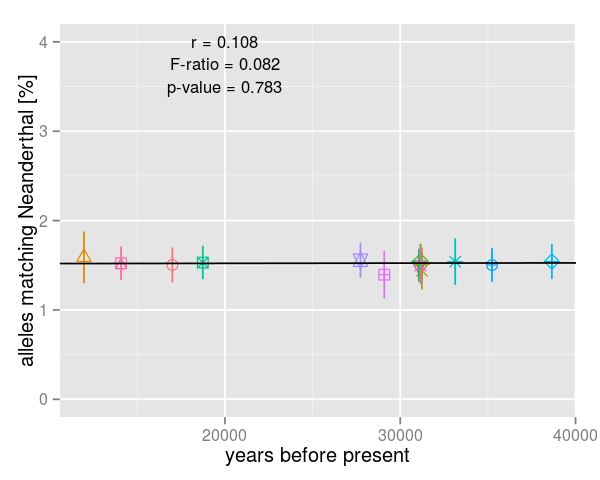

In [34]:
time_correlation_test(filter(jk_admix_df, (! name %in% c("Ust-Ishim", "French", "Han", "Sardinian"))))

<br><br><br><br><br>
# Correlation based on simple binomial estimates of Neanderthal admixture

In [35]:
n <- length(snps_per_sample)
binom_admix_df <- data.frame(name=character(n), n_sites=integer(n), age=integer(n), prop=numeric(n), lower=numeric(n), upper=numeric(n), stringsAsFactors=FALSE)

In [36]:
for (i in seq_along(snps_per_sample)) {
    sample_name <- names(snps_per_sample)[i]
    sample_snps <- snps_per_sample[[i]]
    
    prop_ci <- admixture_prop_ci(sample_snps)
    
    binom_admix_df[i, ] <- list(sample_name,
                                length(sample_snps),
                                sample_ages[which(sample_ages$name == sample_name), "age"],
                                prop_ci["mean"],
                                prop_ci["lower"],
                                prop_ci["upper"])
}

## Binomial estimates &mdash; Including Ust-Ishim and B-team (French control)

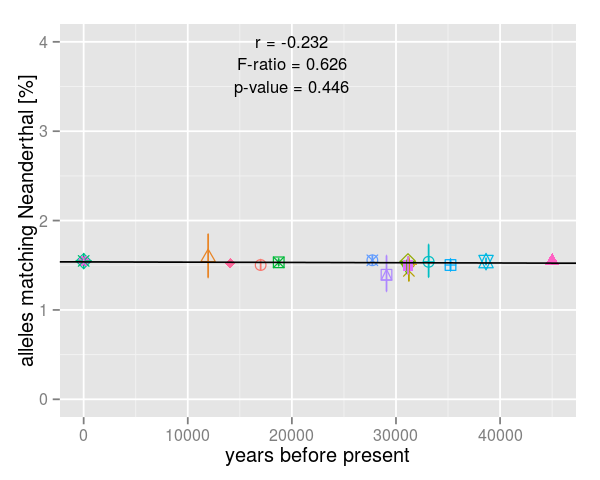

In [37]:
time_correlation_test(binom_admix_df)

## Binomial estimates &mdash; Excluding Ust-Ishim and including B-team (French control)

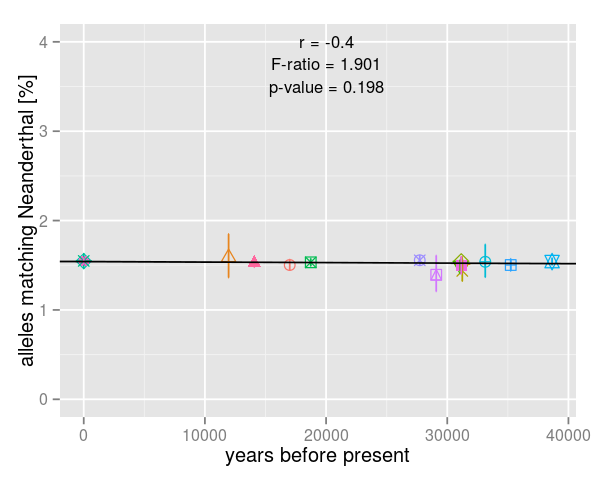

In [38]:
time_correlation_test(filter(binom_admix_df, (! name %in% c("Ust-Ishim"))))

## Binomial estimates &mdash; Including Ust-Ishim and excluding B-team (French control)

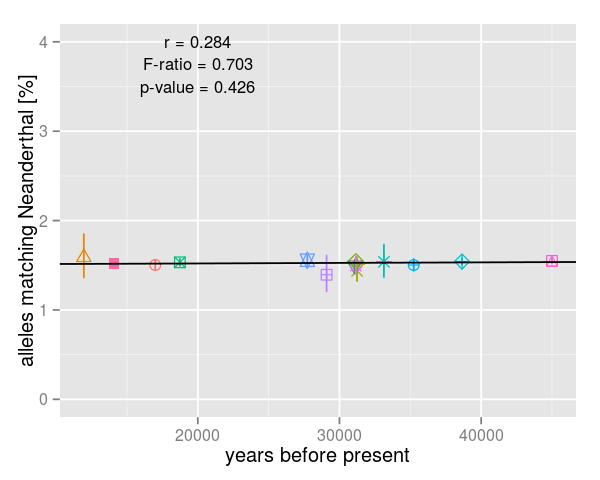

In [39]:
time_correlation_test(filter(binom_admix_df, (! name %in% c("French", "Han", "Sardinian"))))

## Binomial estimates &mdash; Only our capture EMH samples (French control)

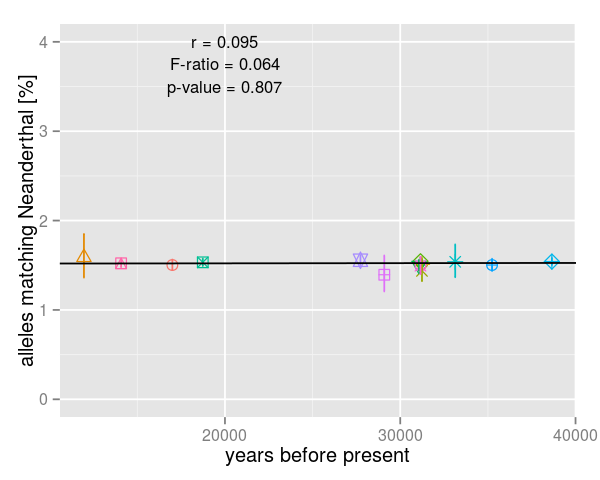

In [40]:
time_correlation_test(filter(binom_admix_df, (! name %in% c("Ust-Ishim", "French", "Han", "Sardinian"))))